In [44]:
import json, os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [45]:
years = ['19-20','20-21','21-22','22-23','23-24']
models = ['DKT', 'SAKT']
fold_nums = range(5)
sample_nums = range(1,11)

In [46]:
f = open('./Data/dkt_results/cy_DKT_19-20_1.json')
j = json.load(f)
f.close()

In [47]:
j

{'20-21': 0.9170764088630676,
 '21-22': 0.9184024930000305,
 '22-23': 0.912988543510437,
 '23-24': 0.9252828359603882}

In [54]:
dkt_wy_dict = {}
dkt_cy_dict = {}
for y in years: # DKT
	dkt_wy_dict[y] = []
	for f in fold_nums:
		with open(f'./Data/dkt_results/wy_DKT_{y}_{f}.json') as wyj:
			obj = json.load(wyj)
			dkt_wy_dict[y].append(obj[y][str(f)])
	if y != '23-24':
		dkt_cy_dict[y] = {}
		for s in sample_nums:
			with open(f'./Data/dkt_results/cy_DKT_{y}_{s}.json') as cyj:
				obj = json.load(cyj)
				for test_year, measurement in obj.items():
					if dkt_cy_dict[y].get(test_year) is None:
						dkt_cy_dict[y][test_year] = {}
					dkt_cy_dict[y][test_year][str(s)] = measurement

In [49]:
sakt_wy_dict = {}
sakt_cy_dict = {}
for y in years: # SAKT
	sakt_wy_dict[y] = []
	for f in fold_nums:
		with open(f'./Data/sakt_results/wy_SAKT_{y}_{f}.json') as wyj:
			obj = json.load(wyj)
			sakt_wy_dict[y].append(obj[y][str(f)])
	if y != '23-24':
		sakt_cy_dict[y] = {}
		for s in sample_nums:
			with open(f'./Data/sakt_results/cy_SAKT_{y}_{s}.json') as cyj:
				obj = json.load(cyj)
				for test_year, measurement in obj.items():
					if sakt_cy_dict[y].get(test_year) is None:
						sakt_cy_dict[y][test_year] = {}
					sakt_cy_dict[y][test_year][str(s)] = measurement

In [55]:
with open('./Data/formatted_results/cross_year_results_DKT.json','w') as f:
	json.dump(dkt_cy_dict,f)

In [51]:
with open('./Data/formatted_results/cross_year_results_SAKT.json','w') as f:
	json.dump(sakt_cy_dict,f)

In [56]:
with open('./Data/formatted_results/within_year_results_DKT.json','w') as f:
	json.dump(dkt_wy_dict,f)

In [53]:
with open('./Data/formatted_results/within_year_results_SAKT.json','w') as f:
	json.dump(sakt_wy_dict,f)

In [66]:
st = "./Data/formatted_results/within_year_results_SAKT.json"
st.split('_')[-1].split('.')[0]

'SAKT'

In [123]:
dir = './Data/formatted_results'
mean_dict = {}
res_dict = {}
for fn in os.listdir(dir):
	f = os.path.join(dir,fn)
	model = fn.split('_')[-1].split('.')[0]
	with open(f,'r') as jf:
		obj = json.load(jf)
	if mean_dict.get(model) is None:
		mean_dict[model] = {}
		res_dict[model] = {}
		print(f'initializing {model}')
	if 'cross' in fn:
		# print(mean_dict)
		for train_y, dc in obj.items():
			for test_year, res in dc.items():
				if mean_dict[model].get(test_year) is None:
					# print(f'Initializing {model} {train_y}')
					mean_dict[model][test_year] = {}
					res_dict[model][test_year] = {}
				df = pd.DataFrame(res.values())
				statsd = df.describe()
				mean_dict[model][test_year][train_y] = statsd[0]['mean']
				res_dict[model][test_year][train_y] =list(res.values())
	else:
		# print(mean_dict)
		for year, nums in obj.items():
			if mean_dict[model].get(year) is None:
				# print(f'Initializing {model} {year}')
				res_dict[model][year] = {}
				mean_dict[model][year] = {}
			df = pd.DataFrame(nums)
			statsd = df.describe()
			mean_dict[model][year][year] = statsd[0]['mean']
			res_dict[model][year][year] = nums

initializing BKT
initializing DKT
initializing PFA
initializing SAKT


In [112]:
mean_dict['DKT']	

{'20-21': {'19-20': 0.8992213606834412, '20-21': 0.875190258026123},
 '21-22': {'19-20': 0.9027201890945434,
  '20-21': 0.9010912239551544,
  '21-22': 0.8944339871406555},
 '22-23': {'19-20': 0.903278648853302,
  '20-21': 0.8950314521789551,
  '21-22': 0.9171041905879974,
  '22-23': 0.8646830081939697},
 '23-24': {'19-20': 0.9061257541179657,
  '20-21': 0.901886111497879,
  '21-22': 0.9198248386383057,
  '22-23': 0.9125036478042603,
  '23-24': 0.8923345685005188},
 '19-20': {'19-20': 0.904333519935608}}

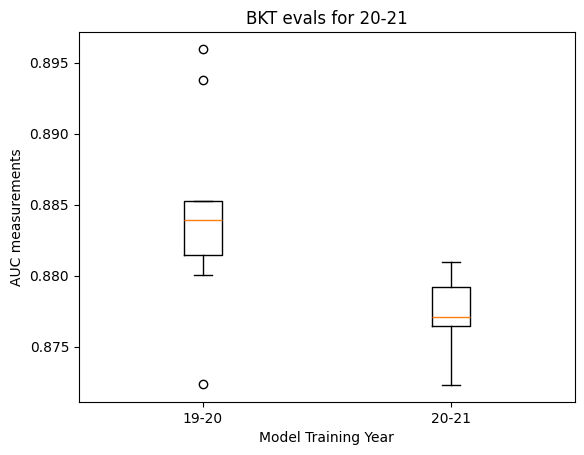

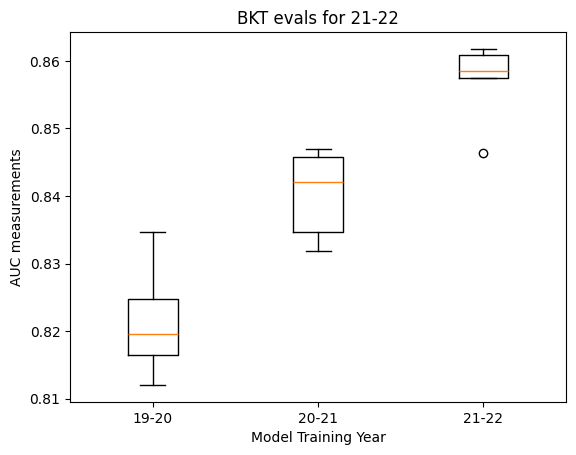

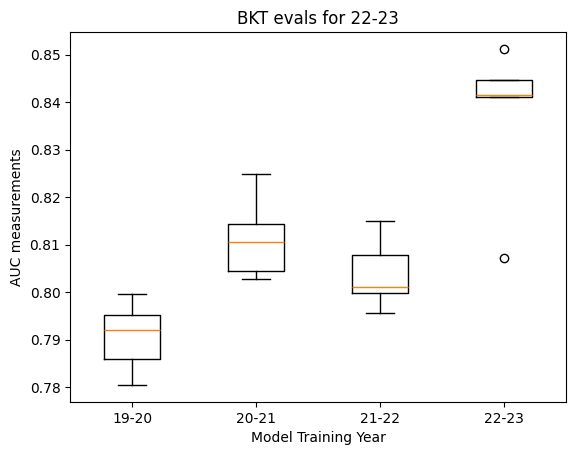

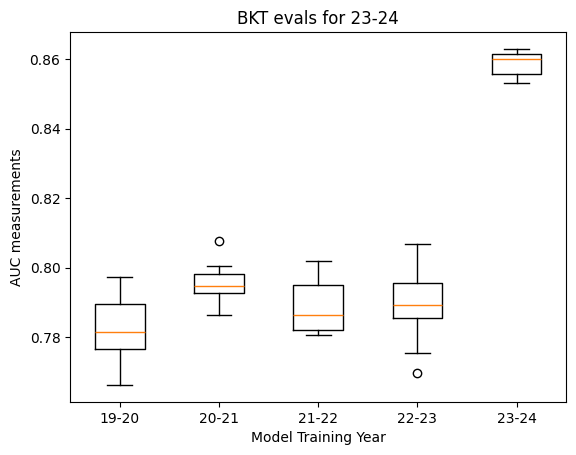

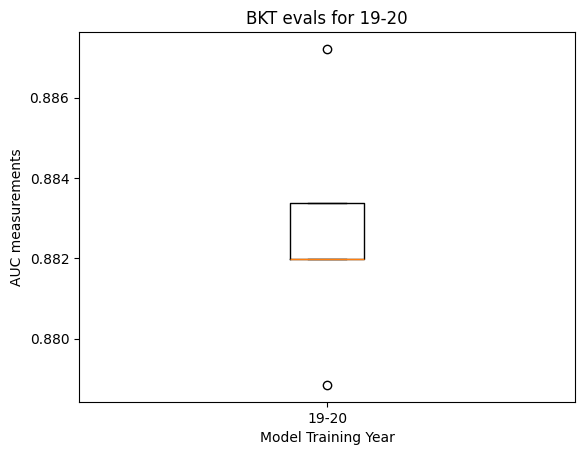

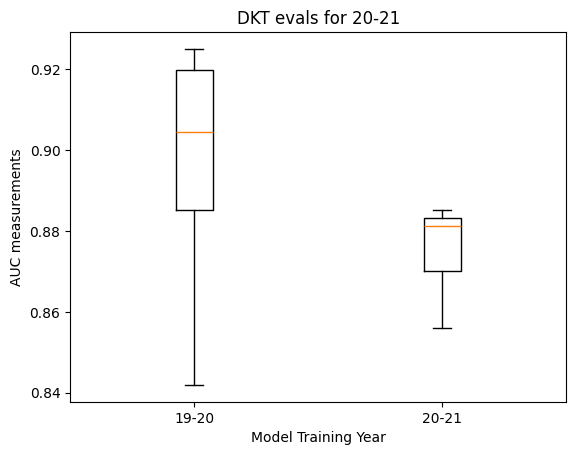

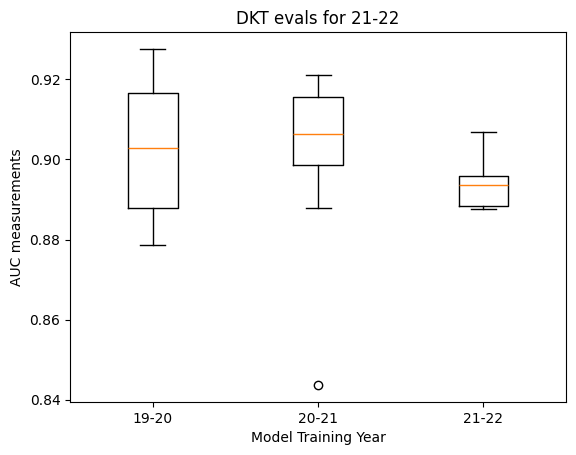

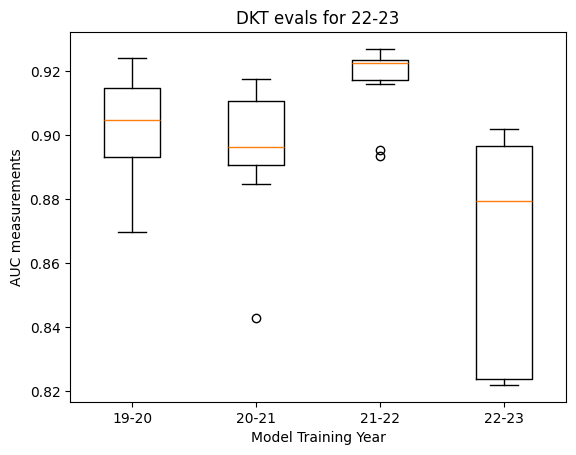

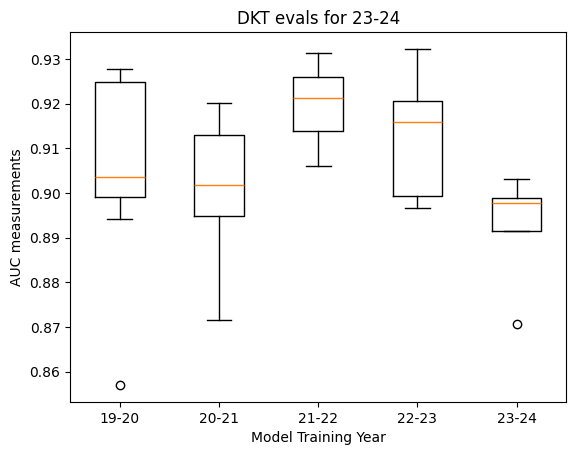

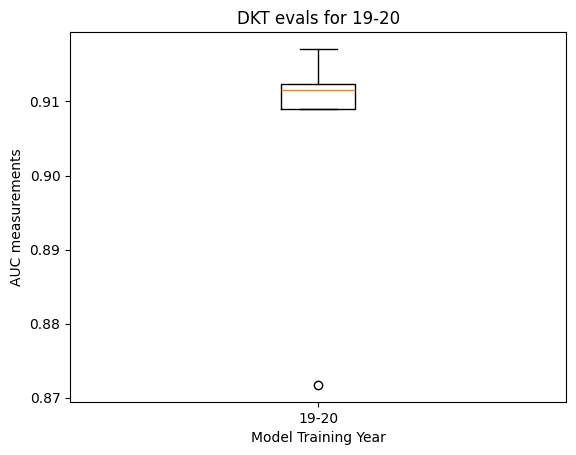

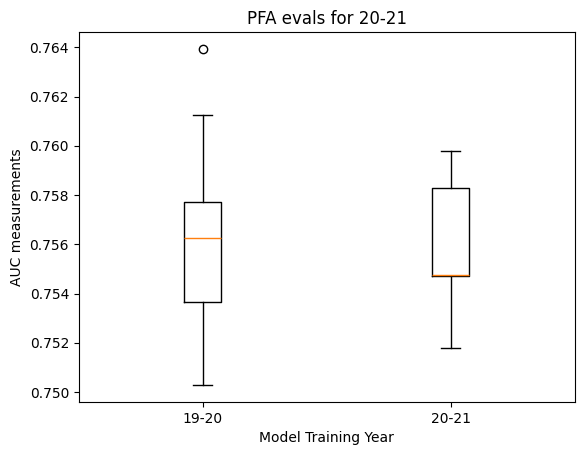

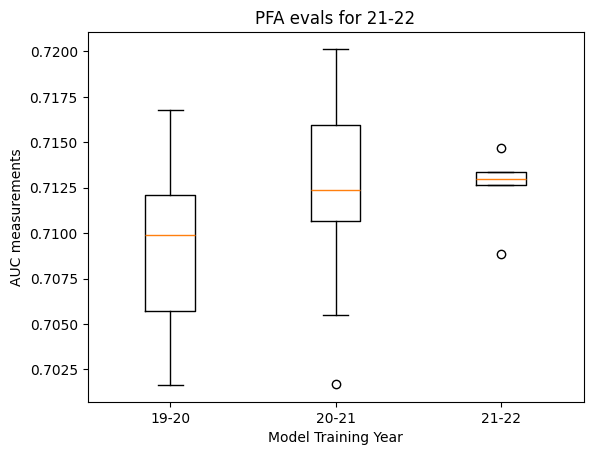

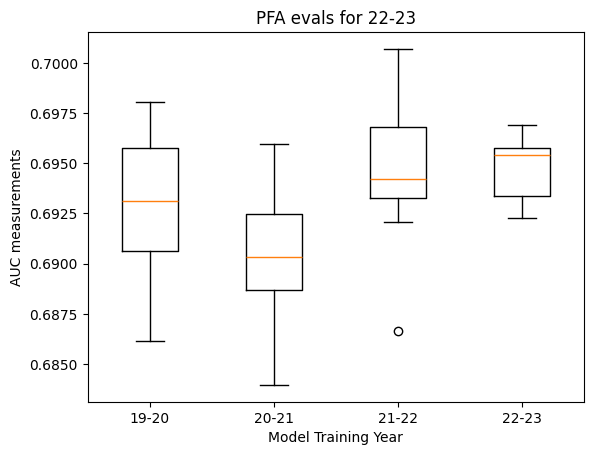

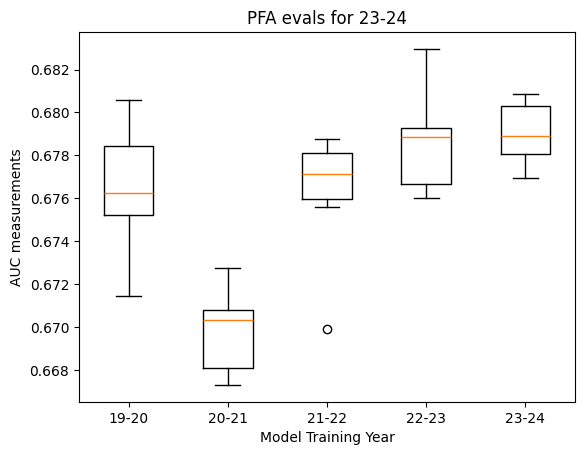

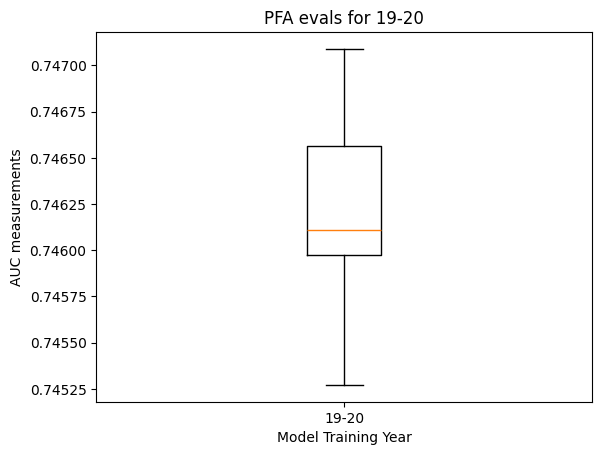

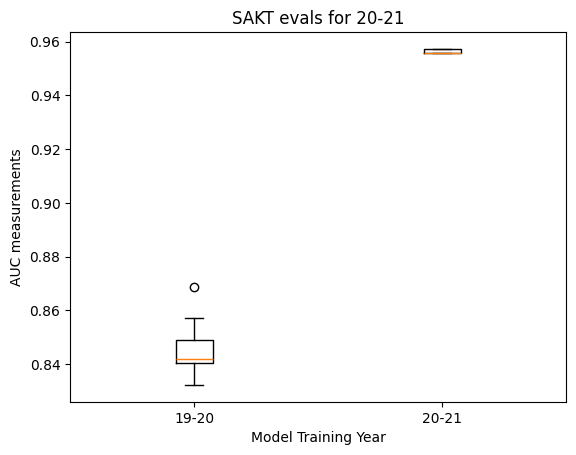

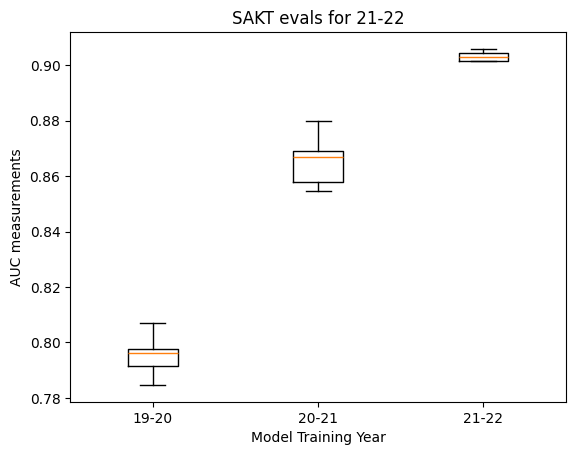

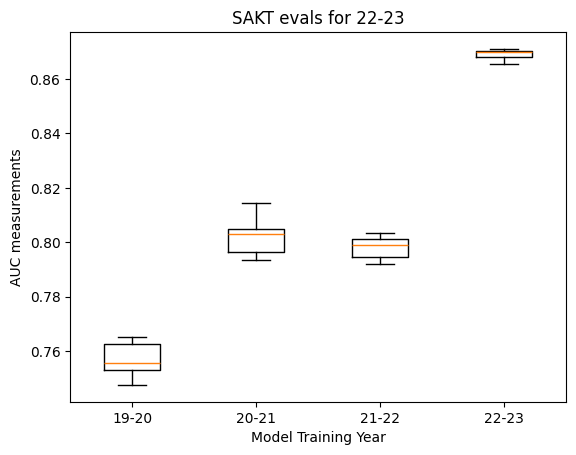

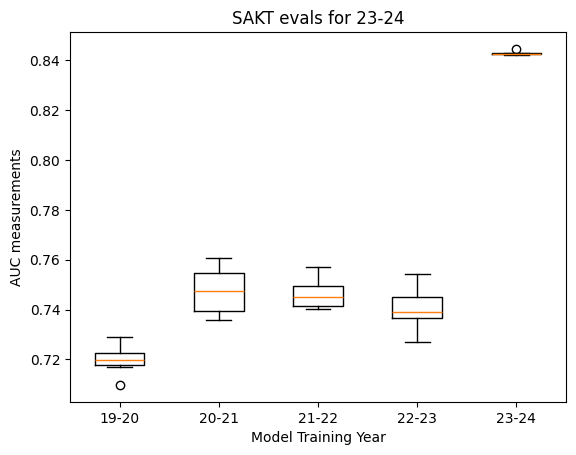

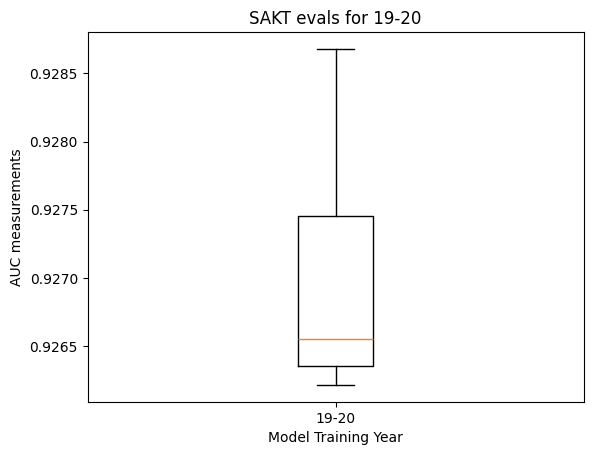

In [207]:
for model, model_dct in res_dict.items():
	for eval_year, dct in model_dct.items():
		train_years = dct.keys()
		aucs = dct.values()
		plt.boxplot(aucs,tick_labels=train_years)
		plt.xlabel('Model Training Year')
		plt.ylabel('AUC measurements')
		plt.title(f'{model} evals for {eval_year}')
		plt.show()

# Statistical testing methodology:
- Run Shapiro-Wilk test on auc data from each test-train pair
- Run Anova on eval years (within model)
- Run Anova on eval years (across models?)

Normality assumption violated for model BKT trained on 22-23 evaluated on 22-23
p=0.04186935117850705


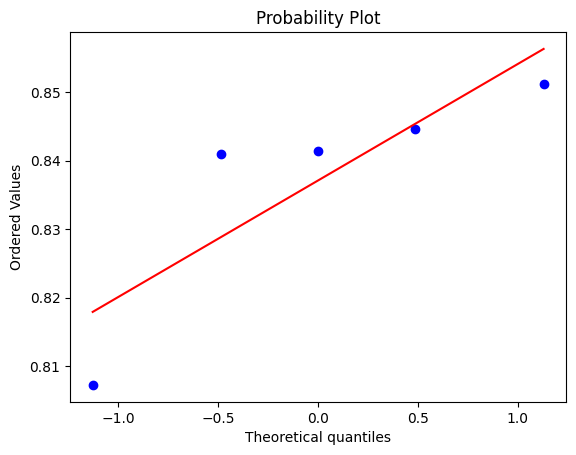

Normality assumption violated for model DKT trained on 20-21 evaluated on 21-22
p=0.009939422127644627


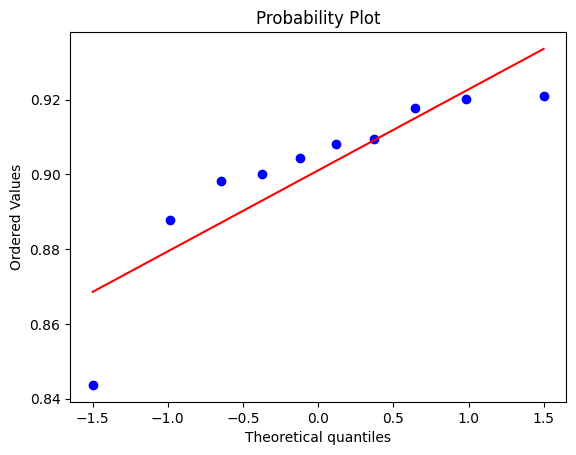

Normality assumption violated for model DKT trained on 20-21 evaluated on 22-23
p=0.04237611684739176


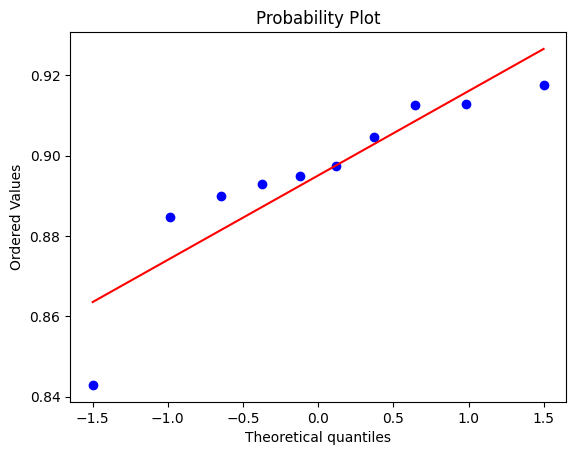

Normality assumption violated for model DKT trained on 21-22 evaluated on 22-23
p=0.001305452041632592


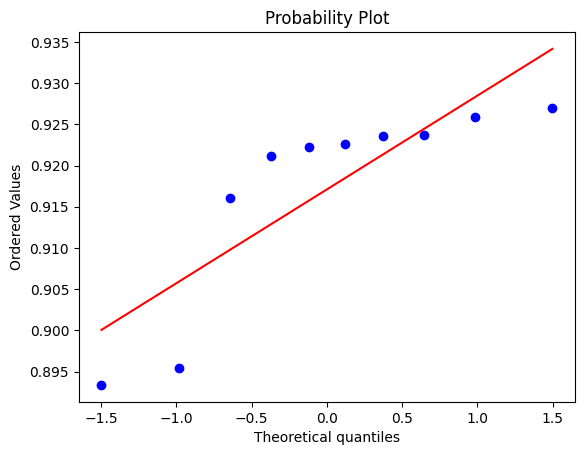

Normality assumption violated for model DKT trained on 19-20 evaluated on 19-20
p=0.010376494746746822


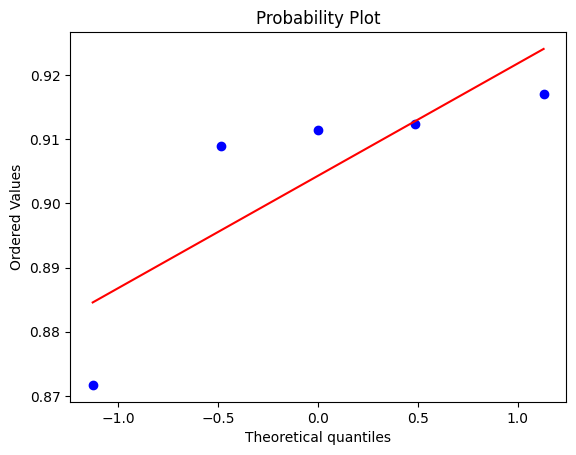

Normality assumption violated for model PFA trained on 21-22 evaluated on 23-24
p=0.0037048299046045703


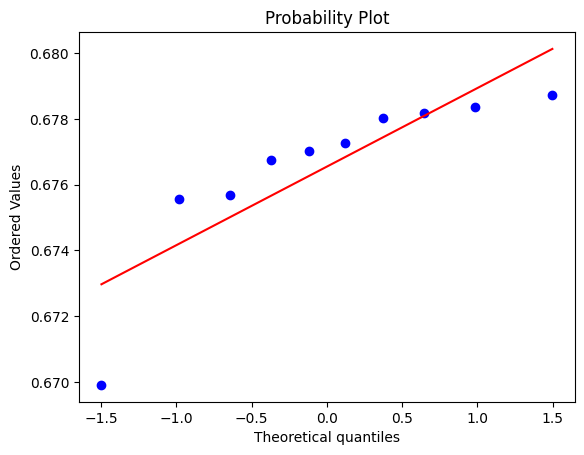

Normality assumption violated for model SAKT trained on 20-21 evaluated on 20-21
p=0.03279612918040538


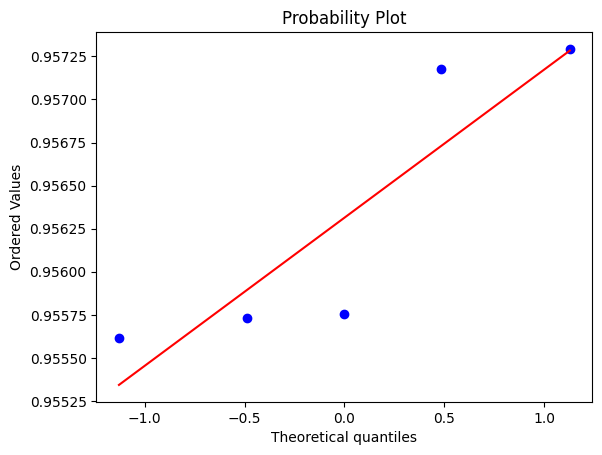

In [176]:
num_nonnormal = 0
total_num = 0
for model, mod_d in res_dict.items():
	for eval_year, year_d in mod_d.items():
		for train_year, nums in year_d.items():
			test_result = stats.shapiro(nums)
			total_num += 1
			if test_result.pvalue <= 0.05:
				print(f"Normality assumption violated for model {model} trained on {train_year} evaluated on {eval_year}")
				print(f'p={test_result.pvalue}')
				stats.probplot(nums,dist='norm', plot=plt)
				plt.show()
				num_nonnormal += 1

In [154]:
num_nonnormal / total_num

0.11666666666666667

In [155]:
total_num - num_nonnormal

53

## Shapiro Wilk results
 Roughly 18% of samples are non-normal w/ alpha of 0.1, down to 11% of samples w/alpha of 0.05. I think using t-tests/ANOVAs to compare samples is warranted.

In [158]:
res_dict['BKT']['23-24']

{'19-20': [0.774396428868752,
  0.7763940784165392,
  0.797450590798063,
  0.7833224232535213,
  0.7898557943527257,
  0.7794700494092256,
  0.7890694437146315,
  0.77768982646727,
  0.7931691624290045,
  0.7662907281834093],
 '20-21': [0.7863225072469627,
  0.7922927635595918,
  0.7936875334423876,
  0.8077831393921384,
  0.8005464034272396,
  0.7939489430359068,
  0.786679815051175,
  0.7952674895845573,
  0.7990307272610782,
  0.7959345462435445],
 '21-22': [0.7847203871698158,
  0.7819125111653789,
  0.7822969527275381,
  0.7805429181239949,
  0.7967513245739568,
  0.7881862448671351,
  0.7898456960862229,
  0.8018893185002279,
  0.7975293465160769,
  0.7811983900265305],
 '22-23': [0.7934207162488169,
  0.7879627556761176,
  0.7854673891693584,
  0.8030573745208275,
  0.7854972542958255,
  0.775379032363128,
  0.7907134061157909,
  0.7696367850457138,
  0.8067105130515573,
  0.7962118612518019],
 '23-24': [0.8530717963240922,
  0.8600623062715199,
  0.8557502061226993,
  0.8613161

In [197]:
# Model Significance Tests
model_test_results = {}
for model, model_dct in res_dict.items():
	model_test_results[model] = {}
	for eval_year, year_d in model_dct.items():
		if len(year_d.keys()) == 1: # Can't really do anything with only one sample
			pass
		elif len(year_d.keys()) == 2: # t-test
			vals = list(year_d.values())
			model_test_results[model][eval_year] = stats.ttest_ind(vals[0],vals[1])
		elif len(year_d.keys()) == 3: # ANOVA
			vals = list(year_d.values())
			model_test_results[model][eval_year] = stats.f_oneway(vals[0],vals[1],vals[2])
		elif len(year_d.keys()) == 4: # ANOVA
			vals = list(year_d.values())
			model_test_results[model][eval_year] = stats.f_oneway(vals[0],vals[1],vals[2],vals[3])
		elif len(year_d.keys()) == 5: # ANOVA
			vals = list(year_d.values())
			model_test_results[model][eval_year] = stats.f_oneway(vals[0],vals[1],vals[2],vals[3],vals[4])

In [188]:
stats.describe(res_dict['BKT']['20-21']['19-20'])

DescribeResult(nobs=10, minmax=(0.8723834641976694, 0.8959601111940414), mean=0.8844466364750062, variance=4.4473304752612244e-05, skewness=0.17553287078717325, kurtosis=-0.08038919675507605)

In [189]:
stats.describe(res_dict['BKT']['20-21']['20-21'])

DescribeResult(nobs=5, minmax=(0.8723066620285268, 0.880982093892321), mean=0.8772019012801839, variance=1.0711654266758643e-05, skewness=-0.4445285919202916, kurtosis=-0.8354845695603301)

In [192]:
stats.ttest_ind(res_dict['BKT']['20-21']['19-20'], res_dict['BKT']['20-21']['20-21'],equal_var=False)

TtestResult(statistic=2.822220671741272, pvalue=0.014420394557720154, df=12.981522884107202)

In [198]:
model_test_results

{'BKT': {'20-21': TtestResult(statistic=2.265580891650577, pvalue=0.04120390798174431, df=13.0),
  '21-22': F_onewayResult(statistic=57.049695728847716, pvalue=1.9689354223441086e-09),
  '22-23': F_onewayResult(statistic=33.34748867626738, pvalue=7.934819081408193e-10),
  '23-24': F_onewayResult(statistic=75.04709538524652, pvalue=4.758290702318597e-18)},
 'DKT': {'20-21': TtestResult(statistic=1.9012020867917814, pvalue=0.07967228475232782, df=13.0),
  '21-22': F_onewayResult(statistic=0.3317485212042875, pvalue=0.7211960338236199),
  '22-23': F_onewayResult(statistic=6.954477386900812, pvalue=0.00103356930221419),
  '23-24': F_onewayResult(statistic=3.6052262673211737, pvalue=0.01334163606857973)},
 'PFA': {'20-21': TtestResult(statistic=0.286948211074109, pvalue=0.7786745453080983, df=13.0),
  '21-22': F_onewayResult(statistic=1.0736647367386798, pvalue=0.3589957467737097),
  '22-23': F_onewayResult(statistic=3.1160311539421697, pvalue=0.04024884363119),
  '23-24': F_onewayResult(st